<h1>EXPLORATORY DATA ANALYSIS - ONLINE RETAIL</h1>

<h2>Introduction</h2>

The <b>Online Retail</b> dataset contains transactional data from a UK-based e-commerce store that sells gifts and decorative items. The dataset records purchases made by customers between 2010 and 2011. In this project, I will perform in-depth analysis on this dataset.

<h2>Dataset Overview</h2>

The dataset includes various attributes related to customer transactions, such as:
<pre>InvoiceNo: Unique identifier for each transaction. 
        
StockCode: Unique product identifier.
        
Description: Name of the product.
        
Quantity: Number of units purchased per transaction.
        
InvoiceDate: Date and time of the transaction.
        
UnitPrice: Price per unit of the product.
        
CustomerID: Unique identifier for each customer.
        
Country: Country where the transaction took place. </pre>

<h2>Preliminary Steps</h2>

<h3>Loading the libraries and modules</h3>

Let's start by loading the essential libraries and modules. We will also set the max columns and max rows display limit to None for Pandas DataFrames to be able to see the whole DataFrame.

In [1]:
import datetime as dt
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

<h3>Defining Utility Functions</h3>

In [2]:
def load_data(directory_path = ''):
    '''
    Loads data from a file into a Pandas DataFrame.
    '''
    try:
        df = pd.read_excel(directory_path)
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {directory_path}")
        return None
    except Exception as e:  
        print(f"An error occurred while reading the Excel file: {e}")
        return None

In [3]:
def nan_df_create(data):
    '''
    Function to create a dataframe of percentage of NaN values for each column of the dataframe
    '''
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df

In [4]:
def plot_orders_over_time(df, column):
    orders_by_month = df.groupby(column)["InvoiceNo"].nunique().reset_index()
    orders_by_month.rename(columns = {"InvoiceNo" : "Number of Orders"}, inplace=True)
    
    plt.figure(figsize=(12,6))
    sns.lineplot(x = column, y = "Number of Orders", data = orders_by_month, marker = "o", linewidth = 2, color = "purple")
    plt.xlabel("Time of the Year")
    plt.ylabel("Number of Orders")
    plt.title("Number of Orders Over Time")
    plt.grid(True, linestyle = '--', alpha = 0.7)
    plt.show()

In [5]:
def plot_sales_trends(sales_df):
    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(sales_df["OrderDate"], sales_df["Quantity"], color = "darkblue", marker = "o", label = "Number of Orders")
    ax1.set_xlabel("Time (Year-Month)", fontsize = 12)
    ax1.set_ylabel("Number of Orders", color = "darkblue", fontsize = 12)
    ax1.tick_params(axis = "y", labelcolor = "darkblue")

    ax2 = ax1.twinx()
    ax2.plot(sales_df["OrderDate"], sales_df["Revenue"], color = "darkred", marker = "s", label = "Revenue")
    ax2.set_ylabel("Revenue (Millions)", color = "darkred", fontsize = 12)
    ax2.tick_params(axis = "y", labelcolor = "darkred")

    ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

    ax1.set_xticks(sales_df["OrderDate"][::2])  
    ax1.set_xticklabels(sales_df["OrderDate"][::2], rotation = 45, ha = "right")

    ax1.legend(loc = "upper left")
    ax2.legend(loc = "upper right")

    plt.title("Sales Trends Over Time", fontsize = 14, fontweight = "bold")
    plt.tight_layout()
    plt.show()

In [6]:
def plot_repeated_customers(repeat_customer_df, repeat_revenue_df):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    repeat_customer_df[['month_year', 'repeated_cus_pct']].set_index('month_year').plot(
        kind = 'line', ax = ax, linewidth = 2, color = 'red', label = 'Repeat Customer %')
    repeat_revenue_df[['month_year', 'repeat_customer_revenue_contribution']].set_index('month_year').plot(
        kind = 'line', ax = ax, linewidth = 2, color = 'blue', linestyle = 'dashed', label = 'Repeat Revenue Contribution')
    
    ax.get_legend().remove()
    ax.spines[['top', 'right']].set_visible(False)
    
    for line in ax.lines:
        xdata = line.get_xdata()
        ydata = line.get_ydata()
        for x, y in zip(xdata, ydata):
            ax.text(x, y + 1, f'{y:.1f}', fontsize = 8, ha = 'center')
    
    plt.xlabel("Order Month-Year")
    plt.ylabel("Percentage")
    plt.title("Repeated Customer Analysis")
    plt.show()

In [7]:
def plot_trending_items_quantity(trending_items_df):
    sns.set_style("whitegrid")
    data = trending_items_df.unstack(level = 1)
    fig, ax = plt.subplots(figsize = (14, 6))
    colors = sns.color_palette("tab10", len(data.columns))

    for idx, stock_code in enumerate(data.columns):
        ax.plot(data.index, 
                data[stock_code], 
                label = f'StockCode {stock_code}', 
                color = colors[idx], 
                linestyle = '-', marker = 'o')

    ax.set_xlabel("Order Year-Month")
    ax.set_ylabel("Quantity Sold")
    ax.set_title("Trending Best-Seller Items: Quantity Over Time")

    ax.legend(title = "Stock Code", bbox_to_anchor = (1.05, 1), loc = "upper left")

    ax.set_xticklabels(data.index, rotation = 45, ha = "right")

    plt.show()

In [8]:
def plot_best_selling_items_by_weekday(df, best_seller_items):
    fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize = (12, 10), sharex = True)
    colors = ['#1f77b4', '#ff7f0e', '#d62728', '#7f7f7f', '#2ca02c']  

    for i, ax in enumerate(axes):
        item_data = df[df['StockCode'] == best_seller_items[i]].groupby('dayinweek')['Quantity'].sum()

        ax.plot(item_data.index, item_data, marker = 'o', linestyle = '-', color = colors[i], label = f"StockCode {best_seller_items[i]}")

        ax.grid(True, linestyle = '--', alpha = 0.6)  
        ax.set_ylabel(f"Stock {best_seller_items[i]}", fontsize = 10, fontweight = 'bold')
        ax.legend(loc = "upper right", fontsize = 9)

    axes[-1].set_xticks(range(7))
    axes[-1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=20, fontsize=10)
    axes[-1].set_xlabel('Day of the Week', fontsize = 12, fontweight = 'bold')

    fig.suptitle("Best-Selling Items: Sales Trend by Weekday", fontsize = 14, fontweight = 'bold')

    plt.tight_layout()
    plt.show()

In [9]:
def recency(x):
    return (df.InvoiceDate.max() - x.max()).days

<h2>EDA</h2>

For the EDA, we will follow these steps:
1. We will first check basic stats like the number of records in tables, number of features, data types of features, etc.
2. Next, we will calculate the NaN percentage and check the duplicated values of this dataset.
3. We will also identify the outliers to prevent potential problems.
4. Finally, we will do some basic data cleaning.

<h3>Loading Data</h3>

In [10]:
df = load_data(directory_path = "C:\\Users\\ADMIN\\Saved Dataset\\Datasets\\Online Retail.xlsx")

<h3>General Stats</h3>

In [11]:
print(f'The shape of Online Retail is: {df.shape}')
print('-'*100)
df.info()
print('-'*100)

The shape of Online Retail is: (541909, 8)
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
----------------------------------------------------------------------------------------------------


<h3>NaN Percentages and Duplicated Values</h3>

In [12]:
nan_df = nan_df_create(df)
print("Columns with NaN values and their percentages:")
display(nan_df[nan_df.percent != 0])
del nan_df

Columns with NaN values and their percentages:


,column,percent
6,CustomerID,24.926694
2,Description,0.268311


**Observations and Conclusions**
1. There are only 2 columns which contain NaN values of the 7 columns from Online Retail.
2. While the Description column only contains a minimal proportion of NaN values, i.e only 0.02%, CustomerID contains a whopping 25% of NaN values. The NaN values in the CustomerID column would be dealt with in the following part.

In [13]:
print(f"Number of rows with duplicated invoice number and stock code: {df[['InvoiceNo', 'StockCode']].duplicated().sum()
                - df.duplicated().sum()}")
print(f"Number of rows with duplicated invoice number, stock code, and customer ID: {df[['CustomerID', 'InvoiceNo', 'StockCode']].duplicated().sum()
                - df.duplicated().sum()}")

Number of rows with duplicated invoice number and stock code: 5416
Number of rows with duplicated invoice number, stock code, and customer ID: 5416


In [14]:
df[df[['CustomerID', 'InvoiceNo', 'StockCode']].duplicated()==True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
125,536381,71270,PHOTO CLIP LINE,3,2010-12-01 09:41:00,1.25,15311.0,United Kingdom
498,536409,90199C,5 STRAND GLASS NECKLACE CRYSTAL,1,2010-12-01 11:45:00,6.35,17908.0,United Kingdom
502,536409,85116,BLACK CANDELABRA T-LIGHT HOLDER,5,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
525,536409,90199C,5 STRAND GLASS NECKLACE CRYSTAL,2,2010-12-01 11:45:00,6.35,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
541697,581538,21194,PINK HONEYCOMB PAPER FAN,1,2011-12-09 11:34:00,0.65,14446.0,United Kingdom
541698,581538,35004B,SET OF 3 BLACK FLYING DUCKS,1,2011-12-09 11:34:00,5.45,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


In [15]:
df[((df['CustomerID'] == 17908.0) & (df['InvoiceNo'] == 536409) & (df['StockCode'] == '90199C'))]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
483,536409,90199C,5 STRAND GLASS NECKLACE CRYSTAL,3,2010-12-01 11:45:00,6.35,17908.0,United Kingdom
498,536409,90199C,5 STRAND GLASS NECKLACE CRYSTAL,1,2010-12-01 11:45:00,6.35,17908.0,United Kingdom
525,536409,90199C,5 STRAND GLASS NECKLACE CRYSTAL,2,2010-12-01 11:45:00,6.35,17908.0,United Kingdom


**Observations and Conclusions**

1. There are 5416 rows with duplicated values in InvoiceNo, StockCode, and CustomerID.
2. If a row has duplicated values in InvoiceNo, StockCode, and CustomerID like the three rows I have selected above, it will be reasonable to assume that a mistake had occurred during data entry stage or a system error had happened. These duplicated rows would be dealt with in the following part.

<h3>Outliers</h3>

In [16]:
df.Quantity.describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [17]:
print(f"Number of rows having quantity values smaller than 0: {df[df['Quantity'] < 0].shape[0]}")

Number of rows having quantity values smaller than 0: 10624


**Observations and Conclusions**

1. Based on the statistics, we could see that the minimum value of the Quantity column is negative, so I have decided to investigate further.
2. From what I have looked up, sometimes a cancelled order can have a negative Quantity value. These orders' invoice numbers usually start with C. I will check whether these are true in the following part.

In [18]:
df[df['Quantity'] < 0].InvoiceNo.str.startswith('C').value_counts(dropna=False)

InvoiceNo
True    9288
NaN     1336
Name: count, dtype: int64

In [19]:
df[df['Quantity'] < 0][df[df['Quantity'] < 0].InvoiceNo.str.startswith('C').isnull()].Description.value_counts()

Description
check                                  120
damages                                 45
damaged                                 42
?                                       41
sold as set on dotcom                   20
                                      ... 
POSSIBLE DAMAGES OR LOST?                1
MERCHANT CHANDLER CREDIT ERROR, STO      1
mystery! Only ever imported 1800         1
sold as 22467                            1
lost                                     1
Name: count, Length: 138, dtype: int64

<Axes: >

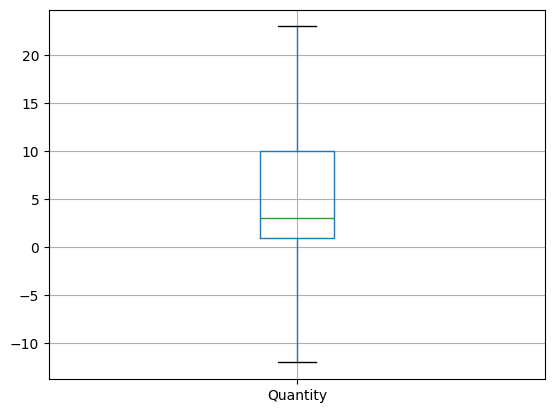

In [20]:
df.boxplot('Quantity', showfliers=False)

In [21]:
# Create a new column to mark cancelled orders 
df['OrderCancel'] = df['InvoiceNo'].str.startswith('C')
df[df['Quantity'] < 0]['OrderCancel'].value_counts(dropna = False)

OrderCancel
True    9288
NaN     1336
Name: count, dtype: int64

<h3>Data Cleaning</h3>

In [22]:
df = df.drop_duplicates(subset = ['InvoiceNo', 'StockCode', 'Quantity'])

In [23]:
df = df[df['CustomerID'].notnull()]

In [24]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['Quantity'] > 0]

In [25]:
df.shape

(392707, 9)

<h2>Time Series Trends Analysis</h2>

Here are the main steps taken to perform the time series analysis on the retail transactions dataset:

**1. Plot Orders Over Time:** Visualize the number of orders over time to understand order frequency, seasonal patterns, and potential anomalies.

**2. Plot Sales Trends:** Compare the trends in the number of orders and revenue simultaneously using a dual chart, which helps in understanding their relationship.

In [26]:
display(df['InvoiceDate'].min())
display(df['InvoiceDate'].max())

Timestamp('2010-12-01 08:26:00')

Timestamp('2011-12-09 12:50:00')

In [27]:
# Create a column to record month and year of the order
df['order_year_month'] = df['InvoiceDate'].dt.strftime('%Y-%m')

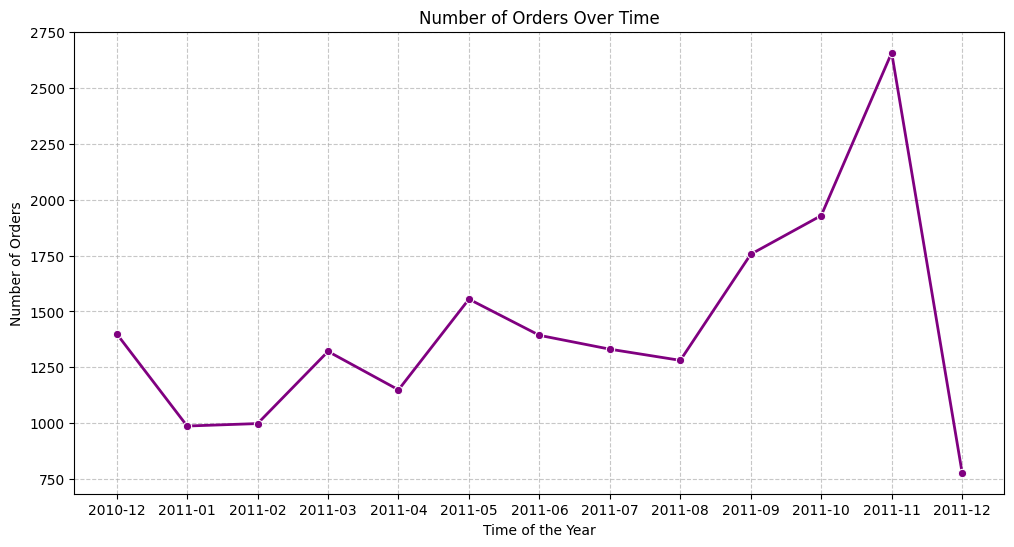

In [28]:
plot_orders_over_time(df, column = 'order_year_month')

**Observations and Conclusions**

1. The number of orders fluctuates over time, with noticeable peaks and drops. There is a *downward trend* from **December 2010 to February 2011**, followed by gradual growth until **May 2011**. A slight decline is observed during the mid-year (June–August 2011), which then shifts into a strong *upward trend* from **September to November 2011**.
2. **December 2010** starts with a high number of orders, likely due to holiday shopping. **January–February 2011** shows a sharp decline, possibly a post-holiday effect. The next months see a gradual increase in sales, until **September–November 2011** demonstrates a strong upward trend, with a peak in November. This might be due to holiday shopping, Black Friday, or other sales events. However, **December 2011** drops dramatically, likely because data collection is incomplete for that month or there is a genuine seasonal decrease after peak shopping months. The drop in this month needs further examination.

In [29]:
display(df[df['order_year_month'] == '2011-12']['InvoiceDate'].min())
display(df[df['order_year_month'] == '2011-12']['InvoiceDate'].max())
# Note that only the orders up to Dec 9 are recorded

Timestamp('2011-12-01 08:33:00')

Timestamp('2011-12-09 12:50:00')

In [30]:
# Filter out incomplete data for December 2011
df = df[df['order_year_month'] < '2011-12']

In [31]:
# Create a new dataframe to record the number of orders
sales_df = df.groupby('order_year_month').InvoiceNo.nunique().reset_index()
sales_df.columns = ['OrderDate', 'Quantity']

In [32]:
# Create a new dataframe to record the revenue
df["Revenue"] = df["UnitPrice"] * df["Quantity"]
revenue_df = df.groupby('order_year_month').Revenue.sum().reset_index()
revenue_df.columns = ['OrderDate', 'Revenue']

In [33]:
# Merge two datasets
sales_df = sales_df.merge(revenue_df, on = 'OrderDate', how = 'left')
sales_df

,OrderDate,Quantity,Revenue
0,2010-12,1400,570158.050
1,2011-01,987,568101.310
2,2011-02,998,446084.920
3,2011-03,1321,593617.960
4,2011-04,1149,464499.161
5,2011-05,1555,677340.300
6,2011-06,1393,660046.050
7,2011-07,1331,598962.051
8,2011-08,1281,643801.040
9,2011-09,1756,950678.021


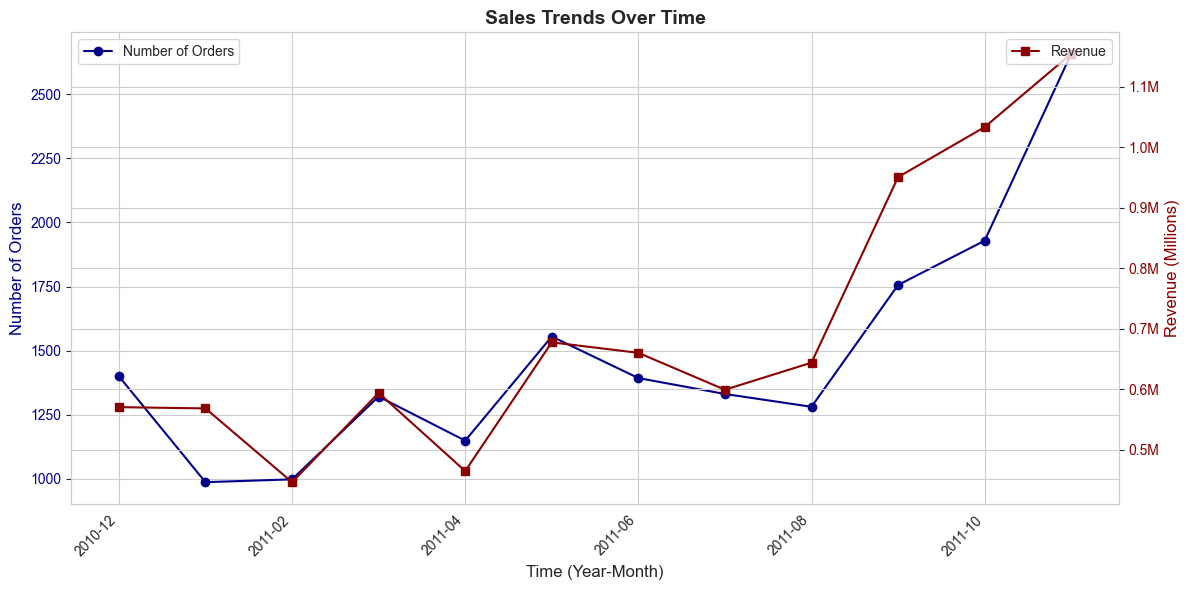

In [34]:
plot_sales_trends(sales_df)

**Observations and Conclusions**

1. **Early Period (2010-12 to 2011-04)**: There is an initial decline in both metrics, followed by fluctuating increases.
2. **Mid-Period (2011-04 to 2011-08)**: The number of orders and revenue both show moderate increases and decreases, maintaining a relatively stable trend.
3. **Late Period (2011-08 to 2011-10)**: A strong increase in both revenue and orders is observed, with revenue growing at a steeper rate than orders, indicating possible price increases or higher-value transactions.

<h2>Repeat Purchases Analysis</h2>

Here are the steps to analyze repeated purchase behavior and its revenue impact over time:

1. **Calculate Monthly Customer Metrics:** Determine the number of customers with repeated purchases each month and the total number of customers making any purchase each month.

2. **Calculate Monthly Percentage of Repeated Customers**: Compute the percentage of repeated customers relative to the total customers each month for further analysis.

3. **Create Repeated Revenue DataFrame**: Build a DataFrame that captures the revenue of repeated customers each month.

4. **Plot Dual Axis Line Chart**: Visualize the relationship between the percentage of repeated customers and the associated revenue over time.

In [35]:
# Calculate number of customers with repeated purchases on each month
grouped_df = df.groupby(['order_year_month', 'CustomerID'])['InvoiceNo'].nunique().reset_index()
repeat_customer_df = grouped_df[grouped_df['InvoiceNo'] >= 2].groupby('order_year_month').CustomerID.count().reset_index()
repeat_customer_df.columns = ['month_year', 'num_repeat_customers']
repeat_customer_df

,month_year,num_repeat_customers
0,2010-12,263
1,2011-01,149
2,2011-02,150
3,2011-03,201
4,2011-04,168
5,2011-05,279
6,2011-06,219
7,2011-07,227
8,2011-08,196
9,2011-09,271


In [36]:
# Calculate number of customers on each month
full_customer_df = grouped_df.groupby('order_year_month').CustomerID.count().reset_index()
full_customer_df.columns = ['month_year','num_customers']
full_customer_df

,month_year,num_customers
0,2010-12,885
1,2011-01,741
2,2011-02,758
3,2011-03,974
4,2011-04,856
5,2011-05,1056
6,2011-06,991
7,2011-07,949
8,2011-08,935
9,2011-09,1266


In [37]:
# Merge two datasets
repeat_customer_df = repeat_customer_df.merge(full_customer_df,on = 'month_year', how = 'left')
repeat_customer_df

,month_year,num_repeat_customers,num_customers
0,2010-12,263,885
1,2011-01,149,741
2,2011-02,150,758
3,2011-03,201,974
4,2011-04,168,856
5,2011-05,279,1056
6,2011-06,219,991
7,2011-07,227,949
8,2011-08,196,935
9,2011-09,271,1266


In [38]:
# Calculate the monthly percentage of repeated customers on each month
repeat_customer_df['repeated_cus_pct'] = round(100 * (repeat_customer_df['num_repeat_customers']
                                                    / repeat_customer_df['num_customers']), 2)
repeat_customer_df

,month_year,num_repeat_customers,num_customers,repeated_cus_pct
0,2010-12,263,885,29.72
1,2011-01,149,741,20.11
2,2011-02,150,758,19.79
3,2011-03,201,974,20.64
4,2011-04,168,856,19.63
5,2011-05,279,1056,26.42
6,2011-06,219,991,22.10
7,2011-07,227,949,23.92
8,2011-08,196,935,20.96
9,2011-09,271,1266,21.41


In [39]:
# Calculate the cumulative revenue of each customer 
grouped_df = df.groupby(['order_year_month', 'CustomerID']).agg({'InvoiceNo' : 'nunique', 'Revenue' : 'sum'}).reset_index()
grouped_df.head(5)

,order_year_month,CustomerID,InvoiceNo,Revenue
0,2010-12,12347.0,1,711.79
1,2010-12,12348.0,1,892.80
2,2010-12,12370.0,2,1864.27
3,2010-12,12377.0,1,1001.52
4,2010-12,12383.0,1,600.72


In [40]:
repeat_revenue_df = grouped_df[grouped_df['InvoiceNo'] >= 2].groupby('order_year_month').Revenue.sum().reset_index()
repeat_revenue_df.columns = ['month_year', 'repeat_customer_revenue'] # Calculate the value of repeated customer on each month

full_revenue_df =  grouped_df.groupby('order_year_month').Revenue.sum().reset_index()
full_revenue_df.columns = ['month_year', 'revenue'] # Calculate the revenue on each month

repeat_revenue_df = repeat_revenue_df.merge(full_revenue_df, on = 'month_year', how = 'left')
repeat_revenue_df['repeat_customer_revenue_contribution'] = round(100 * (repeat_revenue_df['repeat_customer_revenue']
                                                                 / repeat_revenue_df['revenue']), 2)

In [41]:
repeat_revenue_df

,month_year,repeat_customer_revenue,revenue,repeat_customer_revenue_contribution
0,2010-12,357849.24,570158.050,62.76
1,2011-01,218953.76,568101.310,38.54
2,2011-02,189736.82,446084.920,42.53
3,2011-03,265870.64,593617.960,44.79
4,2011-04,190655.38,464499.161,41.05
5,2011-05,377475.69,677340.300,55.73
6,2011-06,375475.61,660046.050,56.89
7,2011-07,317018.05,598962.051,52.93
8,2011-08,315360.14,643801.040,48.98
9,2011-09,495938.13,950678.021,52.17


In [42]:
repeat_customer_df

,month_year,num_repeat_customers,num_customers,repeated_cus_pct
0,2010-12,263,885,29.72
1,2011-01,149,741,20.11
2,2011-02,150,758,19.79
3,2011-03,201,974,20.64
4,2011-04,168,856,19.63
5,2011-05,279,1056,26.42
6,2011-06,219,991,22.10
7,2011-07,227,949,23.92
8,2011-08,196,935,20.96
9,2011-09,271,1266,21.41


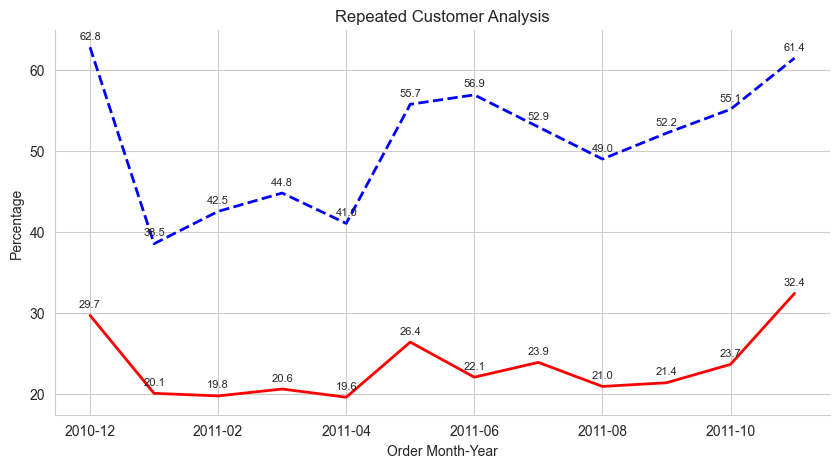

In [43]:
plot_repeated_customers(repeat_customer_df, repeat_revenue_df)

**Observations and Conclusions**

1. Even when the percentage of repeated customers is relatively low, their revenue contribution remains high (~40-60%). This suggests that repeated customers spend more per order compared to new customers.
2. Both metrics rise in late 2011, indicating successful efforts in retaining customers and increasing their spending.
3. Possible action: Since repeated customers contribute significantly to revenue, customer loyalty programs may enhance retention.

<h2>Trending Items Overtime</h2>

Here are the steps to analyze the trends of the best-selling products in the dataset:

1. **Find the Top-Selling Products**: Identify the products with the highest sales performance.
2. **Calculate Monthly Orders and Revenue for Best-Selling Products**: Determine the monthly performance of the top-selling products in terms of order counts and revenue.
3. **Plot Line Chart**: Visualize the trends in orders and revenue over time (monthly and weekly) for the best-selling products.

In [44]:
data_item_df = df.groupby(['order_year_month', 'StockCode']).Quantity.sum().reset_index()

In [45]:
# Rank items by number of orders on the last month
data_item_df[data_item_df['order_year_month'] == '2011-11'].sort_values(by = 'Quantity', ascending = False)

,order_year_month,StockCode,Quantity
27691,2011-11,84826,12551
27069,2011-11,23084,12352
26329,2011-11,22197,8450
26240,2011-11,22086,5909
28087,2011-11,85099B,5677
...,...,...,...
25663,2011-11,20847,1
27854,2011-11,35910B,1
27856,2011-11,35913B,1
26891,2011-11,22870,1


In [46]:
# Find the total number of orders of best-selling items on each month
best_seller_items = [23084, 84826, 22197, 22086, '85099B']
trending_items_df = df[df['StockCode'].isin(best_seller_items)].groupby(['order_year_month', 'StockCode']).Quantity.sum()

In [47]:
# Find the total revenue of best-selling items on each month
trending_items_revenue_df = df[df['StockCode'].isin(best_seller_items)].groupby(['order_year_month', 'StockCode']).Revenue.sum()

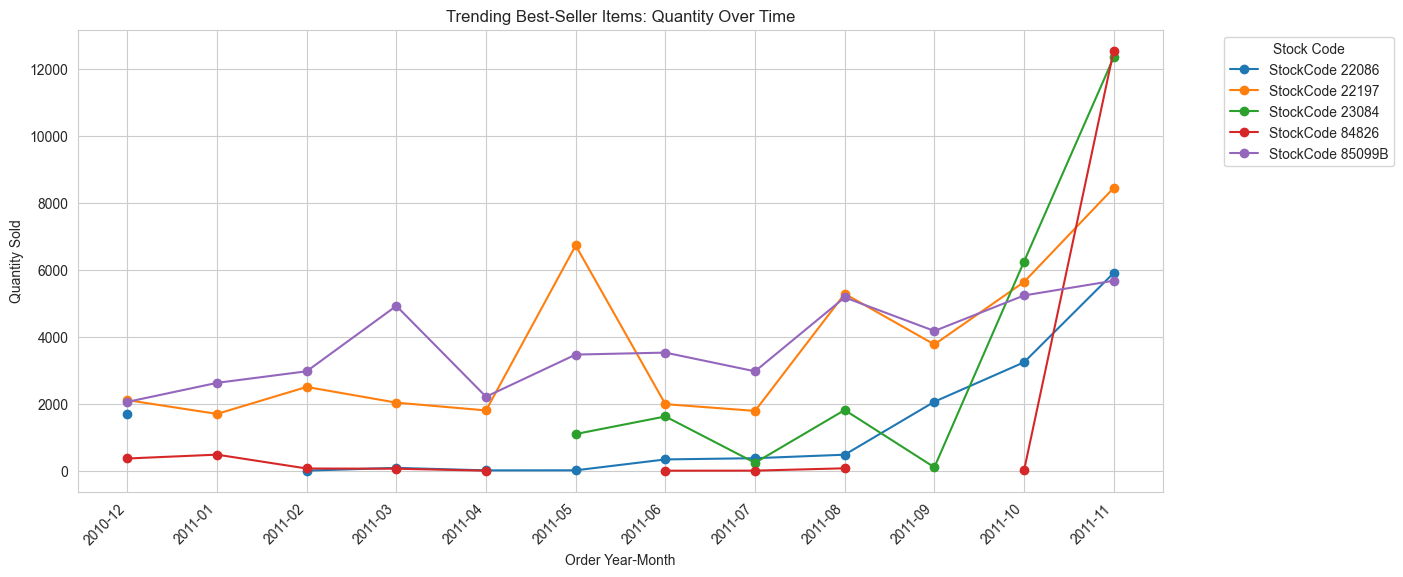

In [48]:
plot_trending_items_quantity(trending_items_df)

**Observations and Conclusions**:
1. Most items show a gradual upward trend over time.
2. Item with StockCode 23084 only started being sold from May 2011, but it gained the lead due to the sudden popularity from September to November 2011.
3. Item with Stock Code 84826 had a minimum quantity sold over time. There are even some months with no orders of this item. However, the quantity sold of this item suddenly spiked in October and November 2011. There were so many orders of 84826 in these months that this item becomes one of the best-selling. This needs further examination.

In [49]:
df[((df['StockCode'] == 84826) & (df['order_year_month'] == '2011-11'))]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,OrderCancel,order_year_month,Revenue
452377,575336,84826,ASSTD DESIGN 3D PAPER STICKERS,4,2011-11-09 13:58:00,0.85,14968.0,United Kingdom,NaN,2011-11,3.40
452421,575337,84826,ASSTD DESIGN 3D PAPER STICKERS,5,2011-11-09 14:11:00,0.85,17867.0,United Kingdom,NaN,2011-11,4.25
452454,575337,84826,ASSTD DESIGN 3D PAPER STICKERS,1,2011-11-09 14:11:00,0.85,17867.0,United Kingdom,NaN,2011-11,0.85
458281,575767,84826,ASSTD DESIGN 3D PAPER STICKERS,1,2011-11-11 11:11:00,0.85,17348.0,United Kingdom,NaN,2011-11,0.85
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256.0,United Kingdom,NaN,2011-11,0.00


**Note**: In November 2011, nearly all of the items with stock code 84826 are given to a customer at price 0.

In [50]:
df['dayinweek'] = df['InvoiceDate'].dt.weekday
df['dayinweek'].value_counts()

dayinweek
3    74638
2    65903
1    63240
0    60894
6    59325
4    51681
Name: count, dtype: int64

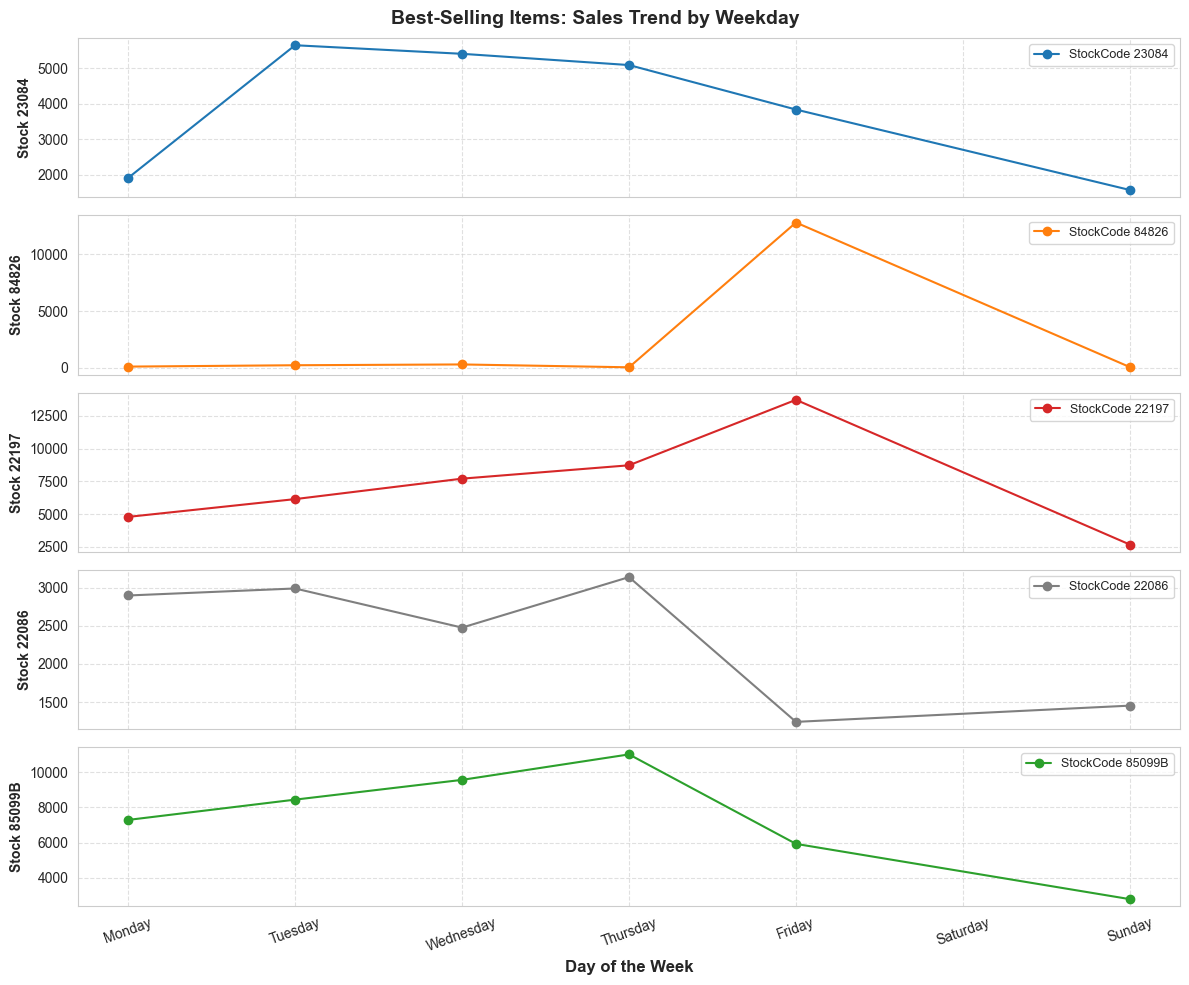

In [51]:
plot_best_selling_items_by_weekday(df, best_seller_items)

<h2>RFM Analysis</h2>

Here are the steps to perform an RFM (Recency, Frequency, Monetary) analysis:

1. Data Preparation

2. Compute RFM Metrics
- **Recency (R):** For each customer, calculate the number of days since their last purchase.
- **Frequency (F):** Count the total number of orders made by each customer.
- **Monetary (M):** Sum the total amount spent by each customer over the period.

3. Score Each RFM Metric
- Use quantiles to rank customers for each metric.
- For Recency, lower values (more recent purchases) should receive higher scores.
- For Frequency and Monetary, higher values should receive higher scores.
- Divide each metric into segments and assign scores accordingly.

4. Combine RFM Scores to Form Overall RFM Score
- Group customers into segments ('Low Value', 'Mid Value' and 'High Value') based on their overall RFM scores.

In [52]:
# Create a new dataframe named customer_df with only a column 'CustomerID'. Each row contains the ID of a CustomerID 
customer_df = pd.DataFrame()
customer_df['CustomerID'] = df.CustomerID.unique()

In [53]:
df['TotalRevenue'] = df['Quantity'] * df['UnitPrice']

In [54]:
df.groupby('CustomerID')[['InvoiceNo']].nunique()
df.groupby('CustomerID').InvoiceNo.nunique().reset_index()

,CustomerID,InvoiceNo
0,12346.0,1
1,12347.0,6
2,12348.0,4
3,12349.0,1
4,12350.0,1
...,...,...
4293,18280.0,1
4294,18281.0,1
4295,18282.0,1
4296,18283.0,15


In [55]:
frequency_df = df.groupby('CustomerID').InvoiceNo.nunique().reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']
customer_df = pd.merge(customer_df, frequency_df, on = 'CustomerID', how = 'left')

In [56]:
monetary_df = df.groupby('CustomerID').TotalRevenue.sum().reset_index()
monetary_df.columns = ['CustomerID', 'Monetary']
customer_df = pd.merge(customer_df ,monetary_df, on = 'CustomerID', how = 'left')

In [57]:
recency_df = (df.InvoiceDate.max() - df.groupby('CustomerID').InvoiceDate.max()).dt.days.reset_index()
recency_df.columns = ['CustomerID', 'Recency']
customer_df = pd.merge(customer_df, recency_df, on = 'CustomerID', how = 'left')

In [58]:
df.groupby('CustomerID').agg({'InvoiceNo' : 'nunique', 'TotalRevenue' : 'sum', 'InvoiceDate' : recency})

,InvoiceNo,TotalRevenue,InvoiceDate
CustomerID,,,
12346.0,1,77183.60,316
12347.0,6,4085.18,30
12348.0,4,1797.24,66
12349.0,1,1757.55,9
12350.0,1,334.40,301
...,...,...,...
18280.0,1,180.60,268
18281.0,1,80.82,171
18282.0,1,100.21,117


In [59]:
customer_df['r_quantile'] = pd.qcut(customer_df['Recency'], q = 4,labels = [4, 3, 2, 1])
customer_df['f_quantile'] = pd.qcut(customer_df['Frequency'], q = 4,labels = [1, 2, 3], duplicates = 'drop')
customer_df['m_quantile'] = pd.qcut(customer_df['Monetary'], q = 4, labels = [1, 2, 3, 4])
customer_df['RFM_Score'] = customer_df[['r_quantile', 'f_quantile', 'm_quantile']].sum(axis=1)

In [60]:
customer_df['RFM_Score'].describe(percentiles = [0.01 * i for i in range(0, 100, 3)])

count    4298.000000
mean        6.710098
std         2.558725
min         3.000000
0%          3.000000
3%          3.000000
6%          3.000000
9%          3.000000
12%         4.000000
15%         4.000000
18%         4.000000
21%         4.000000
24%         4.000000
27%         5.000000
30%         5.000000
33%         5.000000
36%         5.000000
39%         6.000000
42%         6.000000
45%         6.000000
48%         6.000000
50%         6.000000
51%         6.000000
54%         7.000000
57%         7.000000
60%         7.000000
63%         8.000000
66%         8.000000
69%         8.000000
72%         9.000000
75%         9.000000
78%         9.000000
81%        10.000000
84%        10.000000
87%        10.000000
90%        11.000000
93%        11.000000
96%        11.000000
99%        11.000000
max        11.000000
Name: RFM_Score, dtype: float64

In [61]:
customer_df['Segment'] = pd.cut(customer_df['RFM_Score'], bins = [2, 6, 9, 11],labels = ['Low Value', 'Mid Value', 'High Value'])

In [62]:
customer_df['Segment'].value_counts(normalize = True)

Segment
Low Value     0.512797
Mid Value     0.289204
High Value    0.197999
Name: proportion, dtype: float64